## Conceptual
**Why does a static preference dataset become insufficient as a policy improves? Explain using an example: initial model outputs are poor, so human preferences cover only easy mistakes; once the model stops making those, the old data is less relevant. How does online DPO address this?**

1. Offline preference dataset(with preferences samples at the start with SFT model) becomes stale once the model has learnt to rank easy comparisions. As the model learns, old easy mistakes become irrelevant and should learn to compare hard nuances in comparable outputs it generates. Online DPO addresses this by updating(pushing) the D with outputs sampled from model over time. 

## Coding
**Implement a simple simulation of OFS-DPO. Use two copies of a model (e.g., two sets of parameters representing fast and slow). At each iteration: have the fast model generate an output for a query, label its quality with a simulated metric (e.g., a known reward function or a proxy judge), update fast model via DPO loss, and occasionally copy fast weights to slow. Monitor a metric (like the difference between fast and slow policy outputs or rewards over time) to verify that fast adapts quickly and slow provides a stabilizing anchor.**

1. Fast - rapid updates using 
    $$L_{DPO-new}(\theta^F) = L_{DPO}(\theta^F) + \alpha L_{DPO-FS}$$

2. Slow - occasionally fast weights are copied to slow. 

## OFS-DPO Implementation
**Setup:**

**Fast Model (θ^F)**: Updated every iteration via DPO loss. Adapts quickly to new preferences.

**Slow Model (θ^S)**: Updated periodically by copying fast weights. Acts as stabilizing anchor.

**Loss Function**: $L = L_{DPO}(θ^F, \text{ref}=θ^S) + α \cdot KL(π_{fast} || π_{slow})$

**Key Idea:** Fast model learns quickly, slow model prevents it from diverging too far.

In [9]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

In [10]:

np.random.seed(42)

# For simplicity, we model a policy as a distribution over 2 outcomes

initial_logits = np.array([0.0, 0.0])  # Uniform distribution initially

# Simulated reward function: evaluates quality of an output
# In practice: this could be a reward model or human feedback
def reward_function(outcome):
    """Returns reward for an outcome. Outcome 0 is preferred."""
    rewards = {0: 1.0, 1: 0.2}  # Outcome 0 gets much higher reward
    return rewards.get(outcome, 0.0)

# Generate output from a policy given a query
def generate_output(policy_logits):
    """Sample an output from policy distribution."""
    probs = softmax(policy_logits)
    outcome = np.random.choice(len(probs), p=probs)
    return outcome

# Evaluate expected reward of a policy
def evaluate_policy(policy_logits):
    """Compute expected reward of a policy."""
    probs = softmax(policy_logits)
    expected_reward = sum(probs[i] * reward_function(i) for i in range(len(probs)))
    return expected_reward


print(f"Initial policy probabilities: {softmax(initial_logits)}")
print(f"Rewards: outcome_0 -> {reward_function(0):.2f}, outcome_1 -> {reward_function(1):.2f}")
print(f"Initial expected reward: {evaluate_policy(initial_logits):.4f}")
print()

Initial policy probabilities: [0.5 0.5]
Rewards: outcome_0 -> 1.00, outcome_1 -> 0.20
Initial expected reward: 0.6000



In [11]:


def dpo_loss(fast_logits, slow_logits, preferred_outcome, dispreferred_outcome, beta=0.1):
    """
    Compute DPO loss for a preference pair.
    
    Args:
        fast_logits: Logits from fast model
        slow_logits: Logits from slow model (used as reference)
        preferred_outcome: Index of w outcome
        dispreferred_outcome: Index of l outcome
        beta: Temperature parameter
    
    Returns:
        loss: DPO loss value
        grad: Gradient with respect to fast_logits
    """
    # Compute log ratios: log(π_fast / π_slow)
    log_ratio_pref = fast_logits[preferred_outcome] - slow_logits[preferred_outcome]
    log_ratio_dispref = fast_logits[dispreferred_outcome] - slow_logits[dispreferred_outcome]
    
    # DPO loss: -log σ(β * (log_ratio_pref - log_ratio_dispref))
    logit_diff = beta * (log_ratio_pref - log_ratio_dispref)
    sigmoid_val = 1 / (1 + np.exp(-logit_diff))
    loss = -np.log(sigmoid_val + 1e-10)
    
    # Gradient computation
    grad_factor = beta * (1 - sigmoid_val)
    grad = np.zeros_like(fast_logits)
    grad[preferred_outcome] = -grad_factor
    grad[dispreferred_outcome] = grad_factor
    
    return loss, grad

def kl_divergence(logits1, logits2):
    """Compute KL divergence: KL(P1 || P2)"""
    probs1 = softmax(logits1)
    probs2 = softmax(logits2)
    kl = np.sum(probs1 * np.log(probs1 / (probs2 + 1e-10) + 1e-10))
    return kl



In [12]:


def train_ofs_dpo(initial_logits, n_iterations=100, lr=0.1, beta=0.1, alpha=0.1, 
                  copy_frequency=10, outputs_per_iter=3):
    """
    Train using Online Fast-Slow DPO.
    
    At each iteration:
    1. Fast model generates outputs for queries
    2. Outputs are labeled with rewards
    3. Preference pairs are created
    4. Fast model is updated via DPO loss (using slow as reference)
    5. KL divergence penalty is added to prevent fast from diverging
    6. Occasionally, fast weights are copied to slow
    
    Args:
        initial_logits: Starting policy parameters
        n_iterations: Number of training iterations
        lr: Learning rate
        beta: DPO temperature parameter
        alpha: KL divergence penalty weight
        copy_frequency: How often to copy fast weights to slow
        outputs_per_iter: Number of outputs to generate per iteration
    """
    # Initialize fast and slow models (both start from same initial policy)
    fast_logits = initial_logits.copy()
    slow_logits = initial_logits.copy()
    
    # Tracking metrics
    fast_rewards = []
    slow_rewards = []
    policy_divergences = []  # KL divergence between fast and slow
    
    
    for iteration in range(n_iterations):
        
        # Fast model generates outputs for each query
        outputs = [generate_output(fast_logits) for _ in range(outputs_per_iter)]
        
        # Label outputs with rewards 
        rewards = [reward_function(out) for out in outputs]
        
        # Create preference pairs and update fast model
        # Pair outputs and compare rewards to determine preferences
        for i in range(len(outputs) - 1):
            out1, out2 = outputs[i], outputs[i+1]
            rew1, rew2 = rewards[i], rewards[i+1]
            
            # Determine which output is preferred
            if rew1 > rew2:
                pref_w, pref_l = out1, out2
            elif rew2 > rew1:
                pref_w, pref_l = out2, out1
            else:
                continue  # Skip if rewards are equal
            
            # Compute DPO loss (fast vs slow as reference)
            dpo_loss_val, dpo_grad = dpo_loss(
                fast_logits, slow_logits, pref_w, pref_l, beta=beta
            )
            
            # Compute KL divergence penalty: KL(π_fast || π_slow)
            fast_probs = softmax(fast_logits)
            slow_probs = softmax(slow_logits)
            kl_grad = fast_probs - slow_probs  # Gradient of KL divergence
            
            # Combined loss: L_DPO + α * KL
            combined_grad = dpo_grad + alpha * kl_grad
            
            # Update FAST model only
            fast_logits = fast_logits - lr * combined_grad
            
            # Normalize to maintain valid probability distribution
            fast_probs = softmax(fast_logits)
            fast_logits = np.log(fast_probs + 1e-10)
        
        # Occasionally copy fast weights to slow
        if (iteration + 1) % copy_frequency == 0:
            slow_logits = fast_logits.copy()
            if (iteration + 1) % (copy_frequency * 2) == 0:  # Print every other copy
                print(f"  Iteration {iteration+1}: Copied fast → slow")
        
        # Record metrics
        fast_rewards.append(evaluate_policy(fast_logits))
        slow_rewards.append(evaluate_policy(slow_logits))
        policy_divergences.append(kl_divergence(fast_logits, slow_logits))
    
    print("Training complete!\n")
    
    return {
        'fast_logits': fast_logits,
        'slow_logits': slow_logits,
        'fast_rewards': fast_rewards,
        'slow_rewards': slow_rewards,
        'policy_divergences': policy_divergences
    }

# Run training
results = train_ofs_dpo(
    initial_logits,
    n_iterations=100,
    lr=0.15,
    beta=0.1,
    alpha=0.1,
    copy_frequency=10,
    outputs_per_iter=3
)

  Iteration 20: Copied fast → slow
  Iteration 40: Copied fast → slow
  Iteration 60: Copied fast → slow
  Iteration 80: Copied fast → slow
  Iteration 100: Copied fast → slow
Training complete!



RESULTS SUMMARY
Initial expected reward: 0.6000
Final fast model reward: 0.8161
Final slow model reward: 0.8161
Final fast policy: [0.77007408 0.22992592]
Final slow policy: [0.77007408 0.22992592]
Final KL divergence: -0.000000



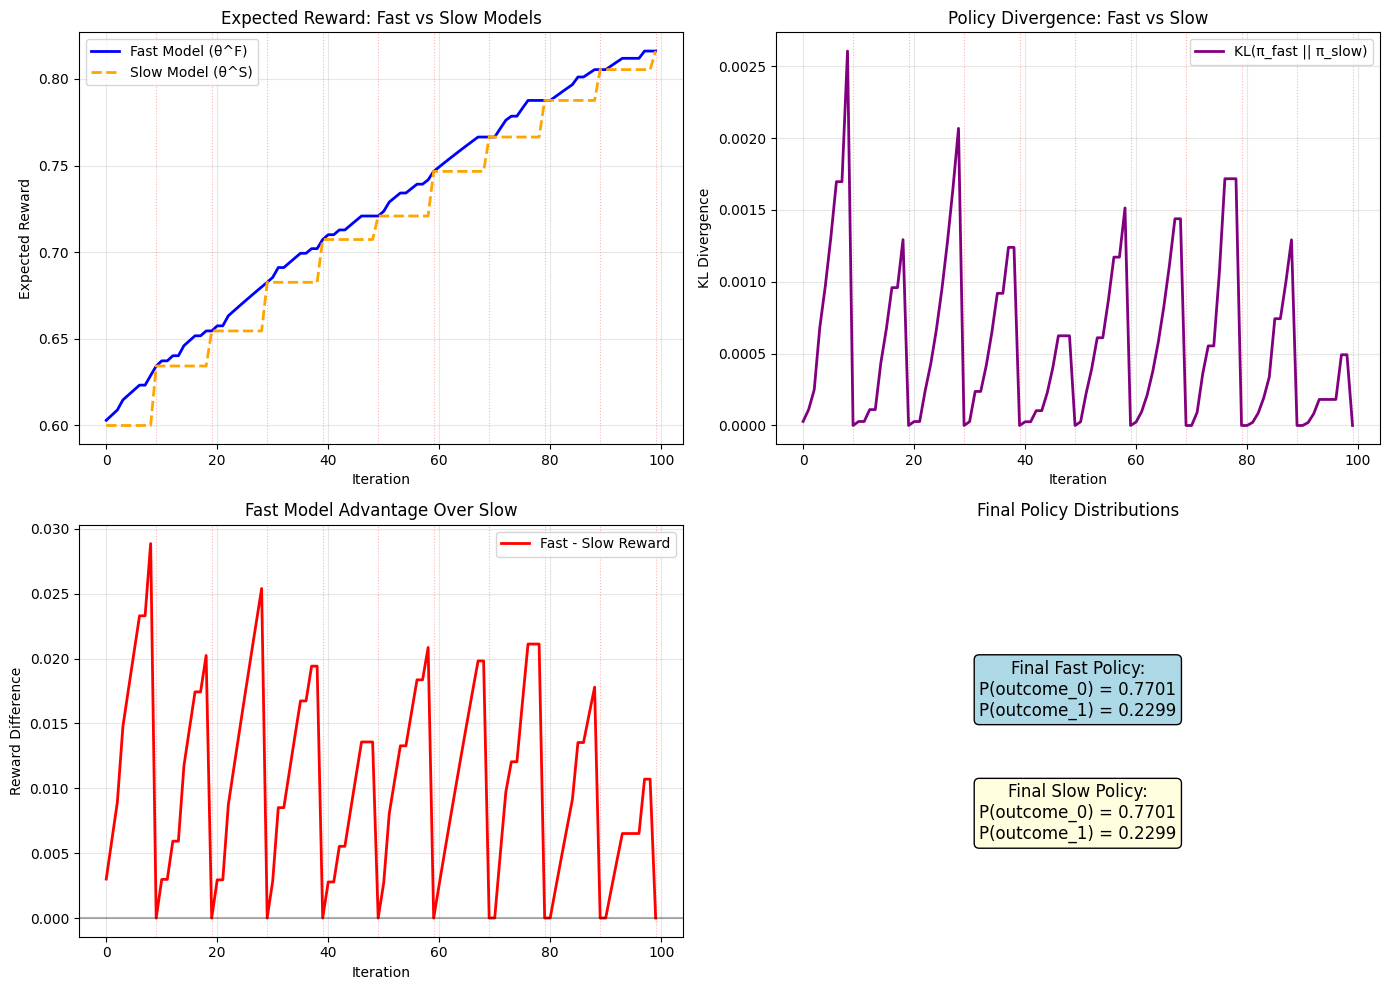

In [14]:


print("="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Initial expected reward: {evaluate_policy(initial_logits):.4f}")
print(f"Final fast model reward: {results['fast_rewards'][-1]:.4f}")
print(f"Final slow model reward: {results['slow_rewards'][-1]:.4f}")
print(f"Final fast policy: {softmax(results['fast_logits'])}")
print(f"Final slow policy: {softmax(results['slow_logits'])}")
print(f"Final KL divergence: {results['policy_divergences'][-1]:.6f}")
print()

# Visualization
iterations = range(len(results['fast_rewards']))
copy_frequency = 10
copy_points = [i for i in range(copy_frequency - 1, len(results['fast_rewards']), copy_frequency)]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Expected Rewards Over Time
ax1 = axes[0, 0]
ax1.plot(iterations, results['fast_rewards'], label='Fast Model (θ^F)', 
         linewidth=2, color='blue')
ax1.plot(iterations, results['slow_rewards'], label='Slow Model (θ^S)', 
         linewidth=2, color='orange', linestyle='--')
for cp in copy_points:
    ax1.axvline(x=cp, color='red', linestyle=':', alpha=0.3, linewidth=0.8)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Expected Reward')
ax1.set_title('Expected Reward: Fast vs Slow Models')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Policy Divergence (KL Divergence)
ax2 = axes[0, 1]
ax2.plot(iterations, results['policy_divergences'], 
         label='KL(π_fast || π_slow)', linewidth=2, color='purple')
for cp in copy_points:
    ax2.axvline(x=cp, color='red', linestyle=':', alpha=0.3, linewidth=0.8)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('KL Divergence')
ax2.set_title('Policy Divergence: Fast vs Slow')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Reward Difference
ax3 = axes[1, 0]
reward_diff = [f - s for f, s in zip(results['fast_rewards'], results['slow_rewards'])]
ax3.plot(iterations, reward_diff, label='Fast - Slow Reward', 
         linewidth=2, color='red')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for cp in copy_points:
    ax3.axvline(x=cp, color='red', linestyle=':', alpha=0.3, linewidth=0.8)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Reward Difference')
ax3.set_title('Fast Model Advantage Over Slow')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Probability of Preferred Outcome
fast_probs_0 = [softmax(results['fast_logits'])[0]] * len(iterations)  # Simplified
# Actually, we need to track this during training, but for now show final state
ax4 = axes[1, 1]
ax4.text(0.5, 0.6, f"Final Fast Policy:\nP(outcome_0) = {softmax(results['fast_logits'])[0]:.4f}\nP(outcome_1) = {softmax(results['fast_logits'])[1]:.4f}", 
         ha='center', va='center', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='lightblue'))
ax4.text(0.5, 0.3, f"Final Slow Policy:\nP(outcome_0) = {softmax(results['slow_logits'])[0]:.4f}\nP(outcome_1) = {softmax(results['slow_logits'])[1]:.4f}", 
         ha='center', va='center', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='lightyellow'))
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])
ax4.axis('off')
ax4.set_title('Final Policy Distributions')

plt.tight_layout()
plt.show()



## How OFS-DPO Works - Step by Step

### Setup
- **Fast Model (θ^F)**: Policy that gets updated every iteration
- **Slow Model (θ^S)**: Policy that gets updated only periodically by copying fast weights
- **Goal**: Learn to prefer outcome 0 (higher reward) over outcome 1

### At Each Iteration:

1. **Generate Queries**: Create inputs (in practice: text prompts)
   - Example: "Explain quantum computing"

2. **Fast Model Generates Outputs**: 
   - For each query, fast model generates an output
   - In practice: π_fast(query) → text completion
   - In simulation: samples from policy distribution

3. **Label Quality**: 
   - Evaluate outputs using reward function
   - In practice: Use reward model r_model(query, output) or human feedback
   - In simulation: outcome 0 gets reward 1.0, outcome 1 gets 0.2

4. **Create Preference Pairs**:
   - Compare outputs and determine which is preferred (higher reward = preferred)

5. **Compute Loss and Update Fast Model**:
   - **DPO Loss**: L_DPO(θ^F, ref=θ^S) - encourages fast to prefer better outputs
   - **KL Penalty**: α * KL(π_fast || π_slow) - prevents fast from diverging too far
   - **Combined**: L = L_DPO + α * KL
   - Update: θ^F = θ^F - lr * ∇L

6. **Copy Fast to Slow** (every N iterations):
   - θ^S = θ^F (copies weights)
   - This resets the anchor point for stability

### Key Insight:
- **Fast model** learns quickly from new preferences
- **Slow model** provides stability by acting as a reference that doesn't change too frequently
- **KL penalty** ensures fast doesn't deviate too far from slow
- Together, this enables fast adaptation while maintaining stability